In [1]:
import numpy as np
import pandas as pd


from average_atom.core.average_atom import NeutralPseudoAtom as NPA
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

from importlib import reload
try:
    reload(physics)
    reload(grids)
    reload(average_atom_geometric)
#     reload(average_atom)
    reload(misc)
except NameError as e:
    from average_atom.core import physics as physics
    from average_atom.core import average_atom as average_atom
    from average_atom.core import misc as misc
    from average_atom.core import grids as grids
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

import cProfile

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (5,3.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14


color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']



Error:  name 'physics' is not defined


In [9]:
# Aluminum
name='Al'
Z, A = 13, 27 

ρ_solid = 2.699 #g/cc, the solid density of aluminum 
ρ = ρ_solid#2.32*ρ_solid#8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)

Ti_eV = 1#.75
Te_eV = 1#.75

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU

####
R = 10*rs
ignore_vxc = True
fixed_Zstar = True
Zstar_init = 'More'

aa_kwargs = {'initialize':True, 'gradient_correction':None, 'μ_init' : 0.158, 'Zstar_init' : Zstar_init, 'Npoints':1000,
             'name':name, 'ignore_vxc':ignore_vxc, 'fixed_Zstar':fixed_Zstar, 'iet_R_over_rs':R/rs, 'iet_N_bins':5000, 'use_full_ne_for_nf':False,
            'gii_init_type': 'step', 'N_stencil_oneside':2}

aaW_kwargs = aa_kwargs.copy()
aaW_kwargs.update({'gradient_correction':'W', 'Weizsacker_λ':1/5})

npa_kwargs = aa_kwargs.copy()
npa_kwargs.update({'Npoints':2000, 'iet_N_bins':5000, 'gii_init_type': 'iet', 'grid_spacing':'geometric'})

npaW_kwargs = npa_kwargs.copy()
npaW_kwargs.update({'gradient_correction':'W', 'Weizsacker_λ':1/5})

aa = NPA(Z, A, Ti_AU, Te_AU, rs, rs, **aa_kwargs)
aaW =NPA(Z, A, Ti_AU, Te_AU, rs, rs, **aaW_kwargs)
npa = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)                           
npaW = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npaW_kwargs)

________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
Intialized Potentials and Densities
Initialized
________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
Intialized Potentials and Densities
Initialized
________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
	-------------------
	Solving IET.
0: Initial condition Total Error: 4.796e+02
Exiting status 0, reverting to best index so far: 1236
Final iter:1237, Total Error: 9.832e-13
Intialized Potentials and Densities
Initialized
________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
	-----


KeyboardInterrupt



In [ ]:
fig, axs  = plt.subplots(1,2,figsize=(10,4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

short_distance_weight = np.exp(-(0.08*npa.kTF*npa.grid.xs)**4)
for ax in axs:
    # ax.plot(npa.iet.r_array*rs, npa.iet.h_r_matrix[0,0], color=colors[0], label=r"NPA: $u_Y$")
    ax.plot(npa.grid.xs, npa.gii-1, color=colors[0], label=r"NPA: $u_Y$")
    # ax.plot(npa_2.grid.xs, npa_2.gii-1,'--', color=colors[0], label=r"NPA: $u_{AA}$",zorder=10)
    ax.plot(aa.iet.r_array*rs, aa.iet.h_r_matrix[0,0],color=colors[1],  label=r"$u_{AA}$")
    # ax.plot(npa.grid.xs, short_distance_weight*(npa.gii-1),'--',color=colors[3],  label=r"$u_Y$ damped")
    			

    # ax.plot(aa.grid.xs, aa.gii-1,'--',color=colors[3],  label=r"$u_Y$")
    ax.axvline(npa.iet.r_array[-1]*rs,color='k')
    
ax = axs[0]
ax.set_xlabel(r"$r/r_i$",fontsize=12)
ax.set_ylabel("h(r)",fontsize=12)
ax.set_xlim(0,3*rs)

ax = axs[1]
ax.set_xlabel(r"$r/r_i$",fontsize=12)
ax.set_ylabel("h(r)",fontsize=12)
ax.set_xscale('log')
ax.set_xlim(0.5,None)
ax.set_yscale('symlog', linthresh=1e-6)
for ax in axs:
    ax.legend(fontsize=12)
    ax.tick_params(labelsize=12)


plt.tight_layout()



### Thomas Fermi (TF)

In [10]:
%%time
from scipy.interpolate import interp1d
aa.solve_TF(verbose=True, picard_alpha=0.5, tol=1e-5, n_wait_update_Zstar= 50)
aa.set_uii_eff()
# aa.iet.HNC_solve(iters_to_wait=1e5, alpha_Picard=1e-2, tol=1e-12, verbose=False, num_iterations=1e5)
# aa.gii = interp1d(aa.iet.r_array*aa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(aa.grid.xs)
# npa_2.gii = interp1d(aa.iet.r_array*aa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(npa.grid.xs)
# aa.make_ρi()

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	μ = -7.799018858e-01, change: 6.376427036e-01 (converged=False)
	φe Err =       -inf, φe change =  6.238e-01
	ne Err =  1.814e-01, ne change =  3.613e-02
	Q =  0.000e+00 ->  2.352e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=False)
	Change =  1.153e+00
__________________________________________
TF Iteration 1
	μ = -5.008745307e-01, change: 3.577723816e-01 (converged=False)
	φe Err =       -inf, φe change =  4.844e-02
	ne Err =  1.423e-01, ne change =  1.887e-02
	Q =  2.352e+00 ->  2.033e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=False)
	Change =  3.794e-01
__________________________________________
TF Iteration 2
	μ = -3.542296872e-01, change: 2.927776009e-01 (converged=False)
	φe Err =       -inf, φe change =  1.570e-02
	ne Err =  8.713e-02, ne change =  8.050e-03
	Q =  2.033e+00 ->  1.558e+00, 
	Zst

###### npa

In [23]:
%%time

npa = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)                           
# transition_func = 1/(1 + np.exp(-(npa.grid.xs-2*npa.rs)/(2*(rs/4)**2)))
# aa_ne_extended = np.zeros_like(npa.ne)
aa_ne_extended[:len(aa.ne)] = aa.ne.copy()
aa_ne_extended[len(aa.ne):] = aa.ne.copy()[-1]
npa.ne = aa_ne_extended# * (1-transition_func) + transition_func * npa.ρi 
npa.μ = aa.μ
npa.Zstar = aa.Zstar

npa.solve_TF(verbose=True, picard_alpha=0.5, tol=1e-9, nmax = 5000, n_wait_update_Zstar= 100)
npa.set_uii_eff()

________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
	Creating Integral Equation Solver
	-------------------
	Solving IET.
0: Initial condition Total Error: 4.796e+02
Exiting status 0, reverting to best index so far: 1236
Final iter:1237, Total Error: 9.832e-13
Intialized Potentials and Densities
Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	μ = 3.683601979e-01, change: 5.750233765e-03 (converged=False)
	φe Err =       -inf, φe change =  1.305e-01
	ne Err =  9.568e-02, ne change =  4.734e-01
	Q =  0.000e+00 ->  9.095e-13, 
	Zstar guess =  3.789e+00. Current Zstar:  2.454e+00 (converged=False)
	Change =  7.532e-01
__________________________________________
TF Iteration 1
	μ = 3.685748191e-01, change: 5.826395400e-04 (converged=True)
	φe Err =       -inf, φe change =  4.586e-01
	ne Err =  3.024e-02, ne change =  1.520e-01
	Q =  9.095e-13 ->  0.000e+00

/home/zach/plasma/average_atom/core/average_atom.py:581: RuntimeWarning: divide by zero encountered in divide
  rel_errs = (np.abs(A @ φe - b)[:-1]/b[:-1])


__________________________________________
TF Iteration 3
	μ = 3.689607049e-01, change: 4.199076816e-04 (converged=True)
	φe Err =       -inf, φe change =  7.399e-02
	ne Err =  1.215e-02, ne change =  2.141e-02
	Q =  4.547e-13 ->  0.000e+00, 
	Zstar guess =  2.450e+00. Current Zstar:  2.448e+00 (converged=False)
	Change =  8.877e-02
__________________________________________
TF Iteration 4
	μ = 3.690472926e-01, change: 2.346798431e-04 (converged=True)
	φe Err =       -inf, φe change =  2.248e-02
	ne Err =  1.062e-02, ne change =  9.114e-03
	Q =  0.000e+00 ->  4.547e-13, 
	Zstar guess =  2.448e+00. Current Zstar:  2.447e+00 (converged=False)
	Change =  2.937e-02
__________________________________________
TF Iteration 5
	μ = 3.690917954e-01, change: 1.205884575e-04 (converged=True)
	φe Err =       -inf, φe change =  3.731e-03
	ne Err =  7.302e-03, ne change =  4.330e-03
	Q =  4.547e-13 ->  0.000e+00, 
	Zstar guess =  2.447e+00. Current Zstar:  2.447e+00 (converged=False)
	Change =  6.883


KeyboardInterrupt



###### aaW

In [16]:
aaW =NPA(Z, A, Ti_AU, Te_AU, rs, rs, **aaW_kwargs)

cutoff_point = 0.02
cutoff_index = np.argmin(np.abs(  cutoff_point - np.array([aa.grid.integrate_f(aa.ne, end_index = i) for i in range(len(aa.ne))])))
guess_tfdw_ne = 1/(  1/aa.ne + 1/aa.ne[cutoff_index])
aaW.ne = guess_tfdw_ne.copy()
aaW.μ  = aa.μ
aaW.Zstar = aa.Zstar

aaW.solve_TF(verbose=True, picard_alpha=1e-1, tol=1e-9, n_wait_update_Zstar= 200)
aaW.set_uii_eff()

________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
Intialized Potentials and Densities
Initialized
Beginning self-consistent electron solver.
_________________________________


/home/zach/plasma/average_atom/core/average_atom.py:589: RuntimeWarning: divide by zero encountered in divide
  rel_errs = (np.abs(A @ φe - b)[:-1]/b[:-1])


__________________________________________
TF Iteration 0
	μ = -1.287281465e+00, change: 4.474651952e+00 (converged=False)
	φe Err =       -inf, φe change =  4.842e-01
	ne Err =  2.717e-01, ne change =  2.100e-02
	Q =  0.000e+00 ->  2.065e-01, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=False)
	Change =  1.619e+00
__________________________________________
TF Iteration 1
	μ = -9.422962962e-01, change: 2.679951339e-01 (converged=False)
	φe Err =       -inf, φe change =  6.587e-02
	ne Err =  2.663e-01, ne change =  1.910e-02
	Q =  2.065e-01 ->  1.858e-01, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=False)
	Change =  2.991e-01
__________________________________________
TF Iteration 2
	μ = -7.515264789e-01, change: 2.024520505e-01 (converged=False)
	φe Err =       -inf, φe change =  1.610e-02
	ne Err =  2.808e-01, ne change =  1.735e-02
	Q =  1.858e-01 ->  1.672e-01, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=False)
	Change = 


KeyboardInterrupt



###### npaW

In [30]:
%%time
npaW = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npaW_kwargs)


cutoff_point = 0.02
cutoff_index = np.argmin(np.abs(  cutoff_point - np.array([npa.grid.integrate_f(npa.ne, end_index = i) for i in range(len(npa.ne))])))
guess_tfdw_ne = 1/(  1/npa.ne + 1/npa.ne[cutoff_index])
npaW.get_Q()
guess_tfdw_ne *= npaW.Qion/npaW.grid.integrate_f(guess_tfdw_ne)
npaW.ne = guess_tfdw_ne.copy()
npaW.μ  = npa.μ
npaW.Zstar = npa.Zstar
npaW.φe = npa.φe.copy()

npaW.solve_TF(verbose=True, picard_alpha=0.01, tol=1e-9, nmax = 1000, n_wait_update_Zstar= 500)
npaW.set_uii_eff()

________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
	Creating Integral Equation Solver
	-------------------
	Solving IET.
0: Initial condition Total Error: 4.796e+02
Exiting status 0, reverting to best index so far: 1236
Final iter:1237, Total Error: 9.832e-13
Intialized Potentials and Densities
Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	μ = 3.730602462e-01, change: 3.434654872e-01 (converged=False)
	φe Err =       -inf, φe change =  2.096e-01
	ne Err =  6.610e-02, ne change =  5.913e-03
	Q =  0.000e+00 ->  0.000e+00, 
	Zstar guess =  4.611e+00. Current Zstar:  2.470e+00 (converged=False)
	Change =  4.637e-01
__________________________________________
TF Iteration 1
	μ = 3.703938253e-01, change: 7.147427079e-03 (converged=False)
	φe Err =       -inf, φe change =  6.005e-02
	ne Err =  7.629e-02, ne change =  2.641e-03
	Q =  0.000e+00 ->  4.547e-1


KeyboardInterrupt



### EOS

In [8]:
def get_Eii(aa):
    βVeff = aa.get_βVeff(aa.φe, aa.ne, aa.ne_bar)
    η = aa.μ/aa.Te - βVeff
    βU = aa.grid.integrate_f(βVeff*aa.ne)
    I_onehalf = FermiDirac.Ionehalf(η)
    I_threehalf = FermiDirac.Ithreehalf(η)
    
    βK = (2*aa.Te)**1.5/π**2 * aa.grid.integrate_f( η*I_onehalf - 2/3 * I_threehalf   )
    return βU, βK, βU + βK

def get_ETF(aa):
    
def get_Exc(aa):
    aa.vxc

def get_E_Hartree(aa):
    
    
    

# get_E(aa_tfd), get_E(npa_tfd)

IndentationError: expected an indented block after function definition on line 11 (2085922158.py, line 13)

In [ ]:
def get_P(aa):
    aa_old_βu = aa.iet.βu_r_matrix.copy()
    # aa.iet.set_βu_matrix( np.array([[1/aa.Ti * aa.Zstar**2/(aa.iet.r_array*aa.rs) ]] ))
    P_id_hnc, P_ex_hnc, P_hnc = aa.iet.ideal_pressure(), aa.iet.excess_pressure(), aa.iet.total_pressure()
    P_id_AU, P_ex_AU, P_AU  = P_id_hnc/rs**3, P_ex_hnc/rs**3, P_hnc/rs**3
    aa.iet.set_βu_matrix(aa_old_βu)
    return P_id_AU, P_ex_AU, P_AU

aa_P_ions = get_P(aa_tfd)
aa_P_ions[1]/aa_P_ions[0]

## Comparison

(<Figure size 4000x1600 with 2 Axes>,
 array([<Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$\\phi$ [A.U.]'>,
        <Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$n$ [A.U.]'>],
       dtype=object))

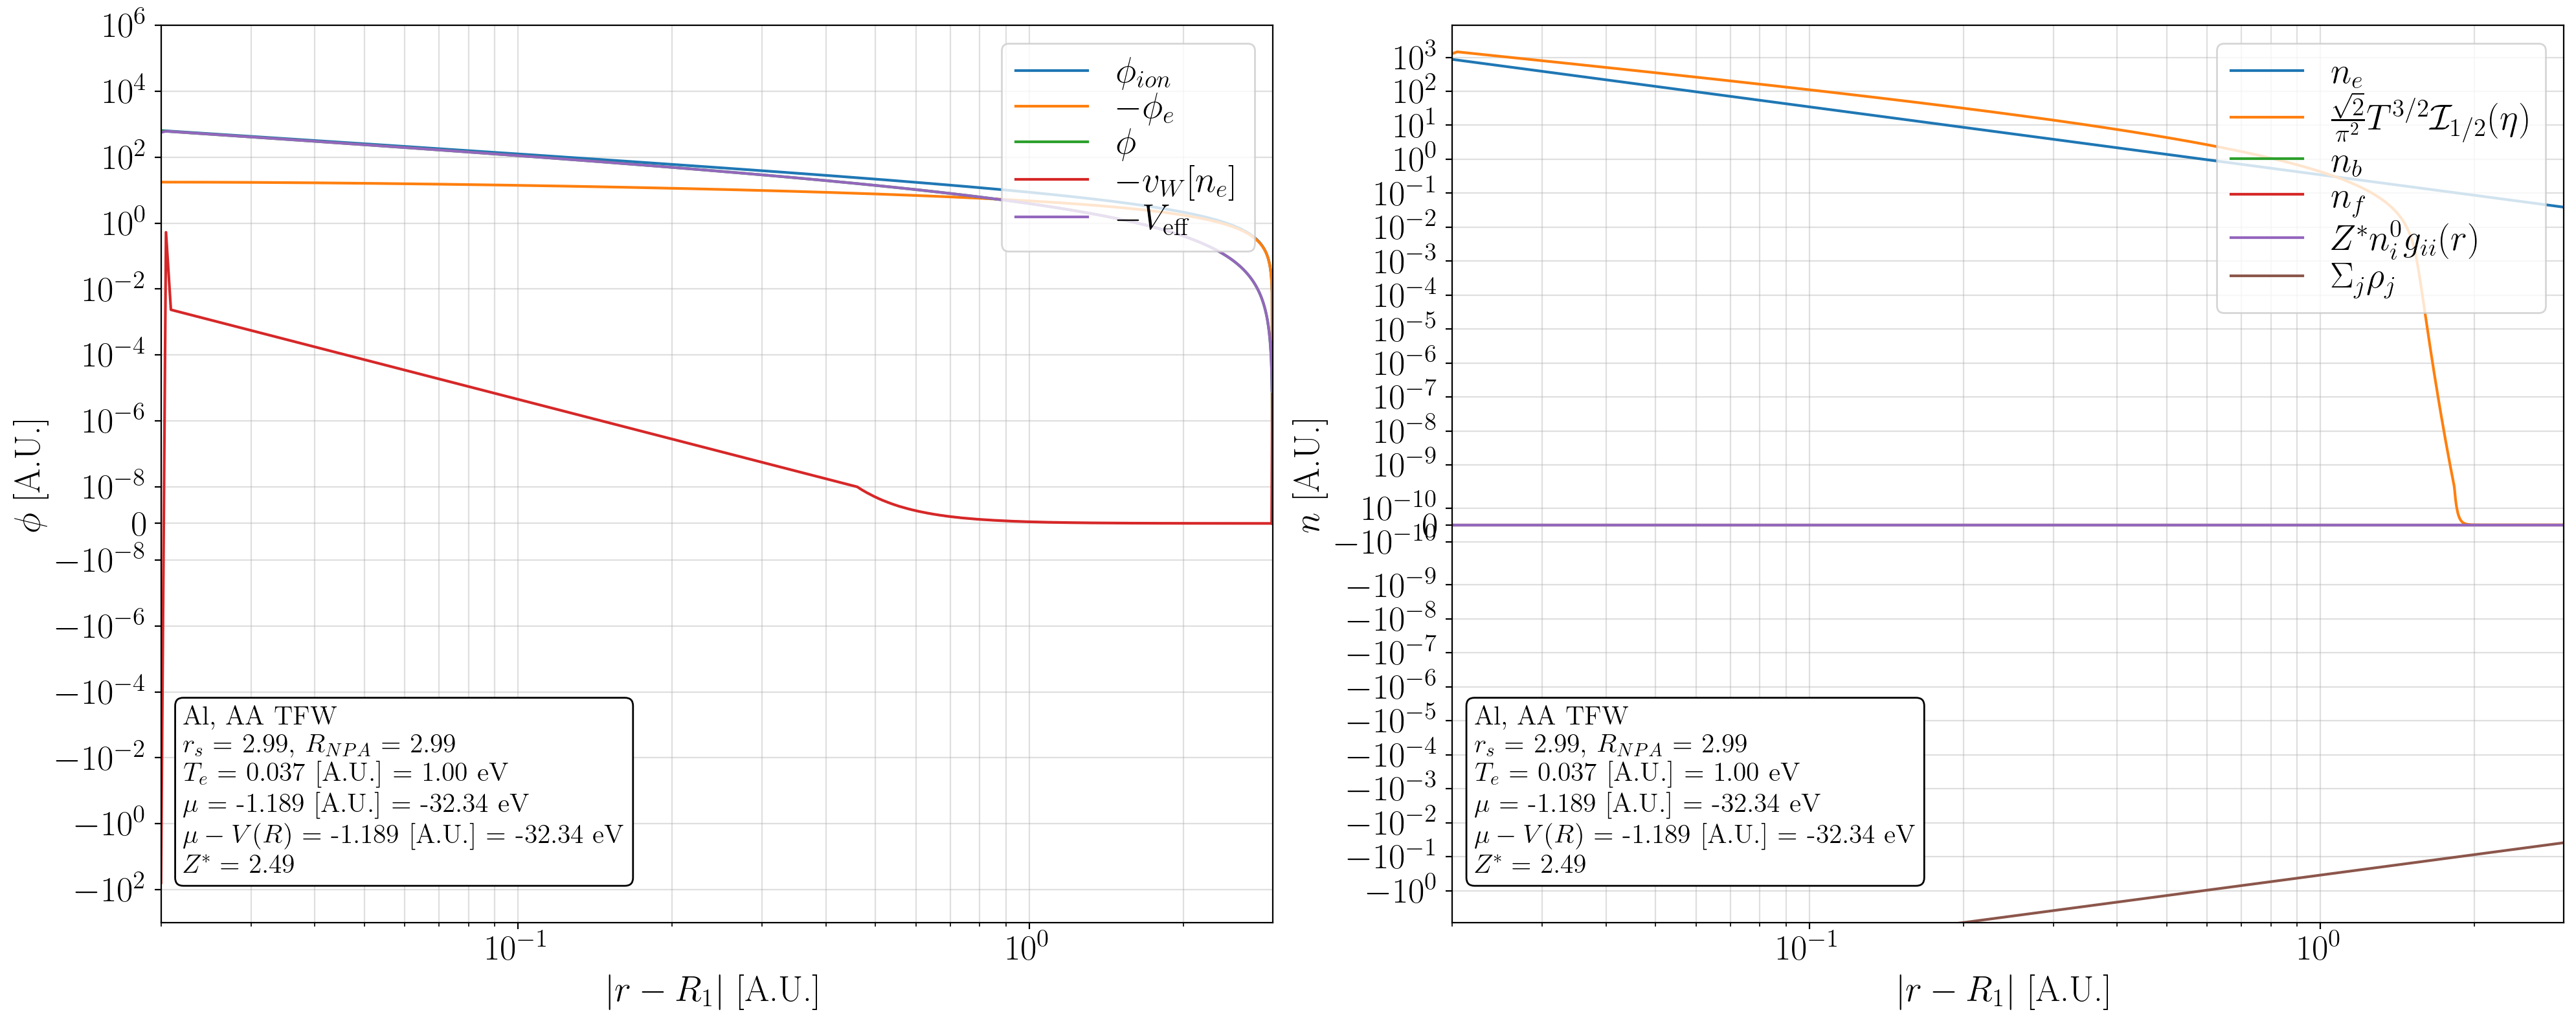

In [17]:
aaW.make_plots()

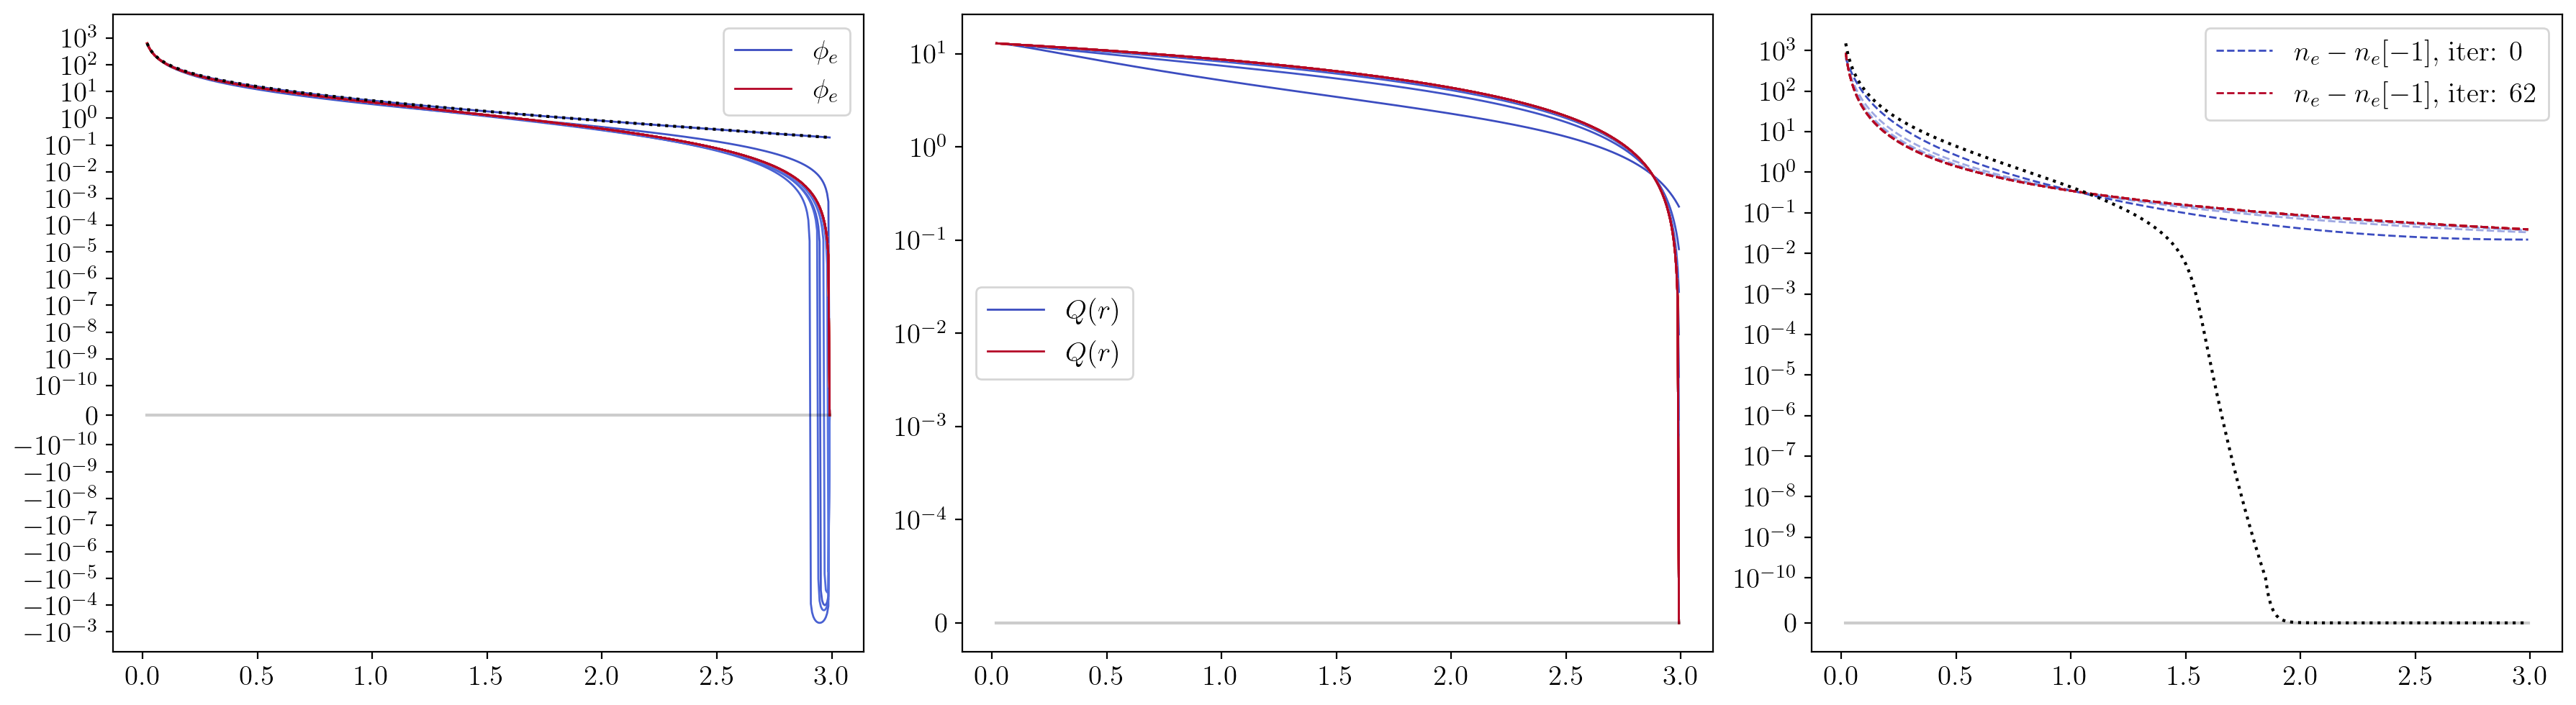

In [21]:
def plot_convergence(aa, axs=None):
    if axs is None:
        fig, axs = plt.subplots(ncols=3,figsize=(18,5),facecolor='w', dpi=200)
    
    # ELectric potential
    slice_by_num = 10
    ax = axs[0]
    colors = plt.cm.coolwarm(np.linspace(0, 1,len(aa.φe_list[::slice_by_num])))
    for i, (φe, ne, μ, ne_bar) in enumerate(zip(aa.φe_list[::slice_by_num], aa.ne_list[::slice_by_num], aa.μ_list[::slice_by_num],aa.ne_bar_list[::slice_by_num])):
        if i ==0 or i==len(aa.φe_list[::slice_by_num])-1:
            ax.plot(aa.grid.xs, (φe+aa.φion),linewidth=1,color=colors[i],alpha=1, label=r'$\phi_e$'.format(i))
            # ax.plot(aa.grid.xs, -aa.grid.dfdx(φe+aa.φion),linewidth=1,color=colors[i],alpha=1, label=r'$\vec E$'.format(i))
            # ax.plot(aa.grid.xs, aa.get_βVeff(φe, ne, ne_bar),linewidth=1,color=colors[i],alpha=1, label=r'$\beta V_{{\rm eff}}$'.format(i))
        else:
            ax.plot(aa.grid.xs, φe+aa.φion,linewidth=1,color=colors[i],alpha=1)
            # ax.plot(aa.grid.xs, -aa.grid.dfdx(φe+aa.φion),linewidth=1,color=colors[i],alpha=1)
            # ax.plot(aa.grid.xs, aa.get_βVeff(φe, ne, ne_bar),linewidth=1,color=colors[i],alpha=1)
    # ax.plot(aa.grid.xs, aa.get_φe( (aa.ρi - aa.ne) )[0] + aa.φion  ,'k:', label=r'$\phi$ check') 
    ax.set_yscale('symlog',linthresh=1e-10)
    ax.plot(aa.grid.xs, aa.φe_init + aa.φion, 'k:')

    # number density
    ax = axs[1]
    for i, (ne, ρi) in enumerate(zip(aa.ne_list[::slice_by_num], aa.ρi_list[::slice_by_num])):
        if i ==0 or i==len(aa.ne_list[::slice_by_num])-1:
            if i==0: 
                ne_bar_0 = ne[-1]
            ax.plot(aa.grid.xs, [aa.grid.integrate_f(-ne + ρi, end_index = index) + aa.Z for index in range(len(aa.grid.xs))],linewidth=1,color=colors[i],alpha=1, label=r'$Q(r)$'.format(i*slice_by_num))
            # ax.plot(aa.grid.xs, -ne + 0*ρi + ne[-1],linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # ax.plot(aa.grid.xs, -ne + ρi,linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # ax.plot(aa.grid.xs, -ne + ne_bar_0,linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # ax.plot(aa.grid.xs, -ρi[-1] + ρi,linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # pass
        else:
            ax.plot(aa.grid.xs, [aa.grid.integrate_f(-ne + ρi, end_index = index) + aa.Z for index in range(len(aa.grid.xs))],linewidth=1,color=colors[i],alpha=1)
            # print(ne[-1]-ne_bar_0)
            # ax.plot(aa.grid.xs, -ne + ρi ,linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            # ax.plot(aa.grid.xs, -ne + ne_bar_0 ,linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            # ax.plot(aa.grid.xs, -ρi[-1]+ ρi ,linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            pass
    # for i in range(int(aa.R/aa.rs)):
    #     ax.axvline(aa.rs*i, color='k', linestyle='--', alpha=0.2)
    # ax.set_xscale('log')
    # ax.plot(aa.grid.xs, (aa.gii)-1, 'k:')
    ax.set_yscale('symlog',linthresh=1e-4)

            
    # number density
    ax = axs[2]
    for i, (φe, ne, μ, ne_bar) in enumerate(zip(aa.φe_list[::slice_by_num], aa.ne_list[::slice_by_num], aa.μ_list[::slice_by_num],aa.ne_bar_list[::slice_by_num])):
        ne_TF = aa.get_ne_TF(φe, ne, μ, ne_bar)
        if i ==0 or i==len(aa.ne_list[::slice_by_num])-1:
            # ax.plot(aa.grid.xs, ne - ne_TF,linewidth=1,color=colors[i],alpha=1, label=r'$n_e/n_e^{{TF}}-1$, iter: {0}'.format(i))
            # ax.plot(aa.grid.xs, ne_TF-ne_TF[-1],linewidth=1,color=colors[i],alpha=1, label=r'$n_e^{{TF}} - n_e^{{TF}}[-1]$, iter: {0}'.format(i*slice_by_num))
            ax.plot(aa.grid.xs, ne-0*ne[-1],linewidth=1,color=colors[i],linestyle='--',alpha=1, label=r'$n_e - n_e[-1]$, iter: {0}'.format(i))
            # pass
        else:
            # ax.plot(aa.grid.xs, ne - ne_TF, linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            # ax.plot(aa.grid.xs, ne_TF-ne_TF[-1],linewidth=1,color=colors[i],alpha=1)
            ax.plot(aa.grid.xs, ne-0*ne[-1], linewidth=1,linestyle='--',color=colors[i],alpha=0.5)
            

            # print(np.abs(ne/ne_TF-1))
            # print(np.where( np.abs(ne/ne_TF-1)>1e-6 ))
            # print(aa.grid.xs[np.where( np.abs(ne/ne_TF-1) > 1e-8)][0]/10, 1/(np.sum(aa.grid.xs*np.abs(ne/ne_TF-1))/np.sum(np.abs(ne/ne_TF-1))))
    # ax.set_ylim()
    # ax.plot(aa.grid.xs, npa.get_ne_TF(npa.φe, npa.ne, npa.μ, npa.ne_bar) - npa.get_ne_TF(npa.φe, npa.ne, npa.μ, npa.ne_bar)[-1] , 'k:')
    ax.plot(aa.grid.xs, aa.get_ne_TF(aa.φe, aa.ne_bar*np.ones_like(aa.ne), aa.μ, aa.ne_bar) - aa.get_ne_TF(aa.φe, aa.ne_bar*np.ones_like(aa.ne), aa.μ, aa.ne_bar)[-1] , 'k:')
    ax.set_yscale('symlog',linthresh=1e-10)
    # ax.set_xscale('log')
    for ax in axs:
        ax.legend(fontsize=14)
        ax.tick_params(labelsize=14)
        ax.plot(aa.grid.xs, np.zeros_like(aa.ne),'k', alpha=0.2)
    plt.tight_layout()
    
# plot_convergence(aa)
plot_convergence(aaW)

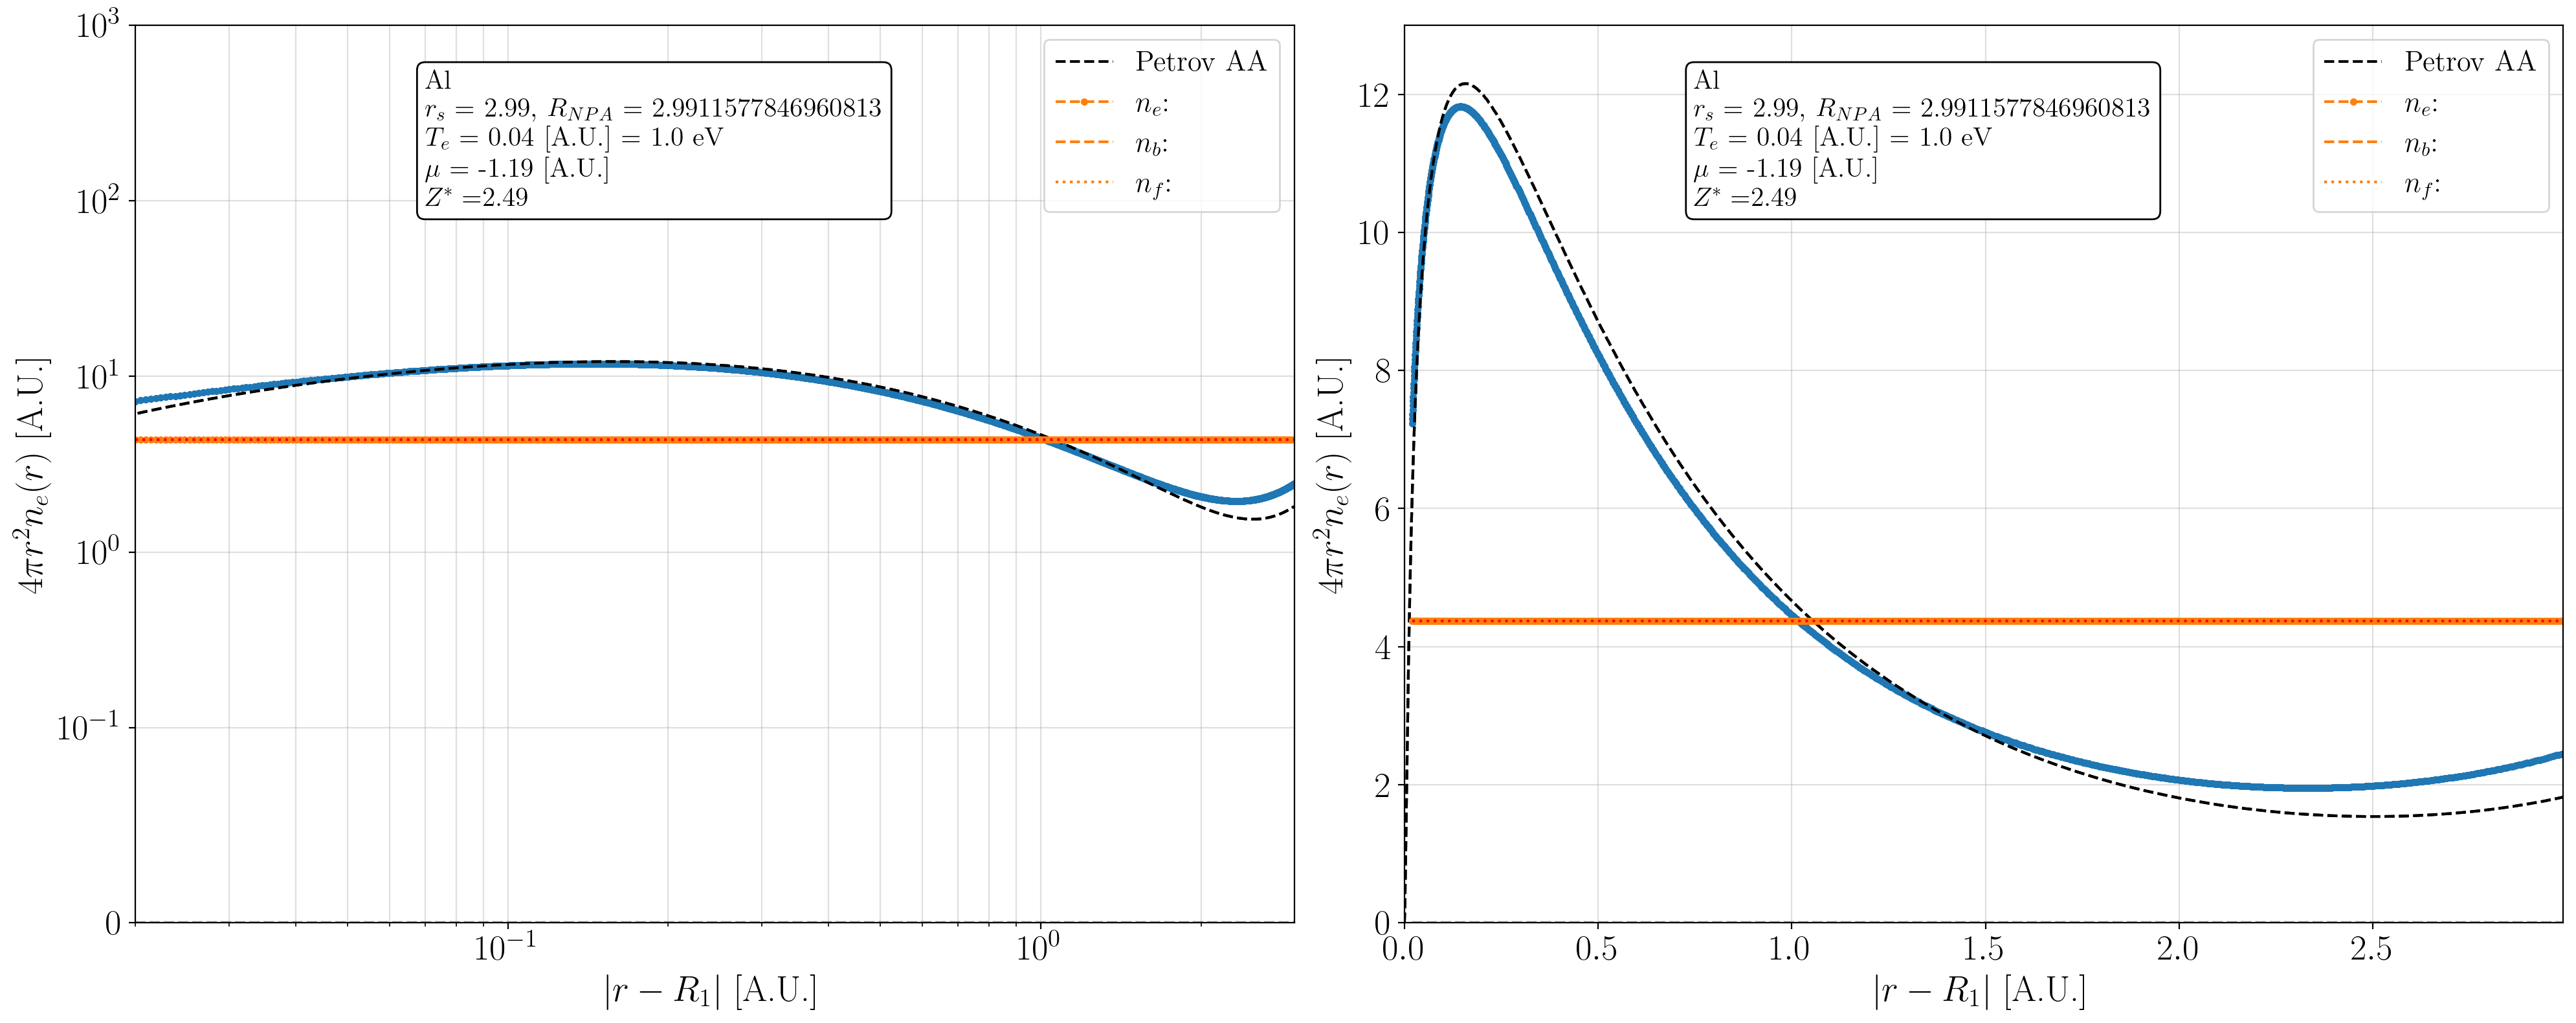

In [22]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

petrov = pd.read_csv("../data/George_Petrov/GP_TFDW_Al_1eV_solid.dat",header=0, comment='#', delim_whitespace=True)

def compare_aa(aa_list, axs=None, name=''):
    eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
    if axs is None:
        fig, axs = plt.subplots(ncols=2,figsize=(20,8),facecolor='w')

    # Density * 4pi r^2 plot
    for ax in axs:
        for aa, color in zip( aa_list, colors):
            factor = 4*np.pi*aa.grid.xs**2
            ax.plot(np.array(petrov['r/R'])*rs, 4*π*(np.array(petrov['r/R'])*rs)**2*(petrov['ne']/m_to_AU**3), 'k--', label="Petrov AA")
            ax.plot(aa.grid.xs, aa.ne*factor ,'--.',color=color, label=r'$n_e$: '+ name)
            # try:
            #     ax.plot(npa.grid.xs, (aa_ne_extended * (1-transition_func) + transition_func * npa.ρi )*factor ,'-',color='b', label=r'$n_e$: '+ name)
            # except:
            #     pass
            ax.plot(aa.grid.xs, aa.n_b*factor,'--',color=color,  label=r'$n_b$: ' + name)
            ax.plot(aa.grid.xs, aa.n_f*factor,':',color=color,  label=r'$n_f$: ' + name)
            if aa.rs != aa.R:
                ax.plot(aa.grid.xs, aa.ρi*factor,'-',color='r',  label=r'$\rho_i$: ' + name)
                ax.plot(aa.grid.xs, (aa.ρi-aa.ne)*factor,'--',color='r',  label=r'$\rho_i+\rho_e$: ' + name)
        # axs[0].plot(aa.grid.xs, aa.δn_f*factor,'--',color='g',  label=r'$n_e^{sc}$: ' + name)
    for ax in axs:
        pass
        # ax.plot(aa.grid.xs, aa.ne_check*factor, 'k')
        ax.plot(aa.grid.xs, aa.get_ne_W()*factor, 'r:' )#aa.φe, aa.ne, aa.μ, aa.ne_bar)*factor, 'r')
        # ax.plot(aa.grid.xs, aa.get_ne_TF(aa.φe, aa.ne, aa.μ, aa.ne_bar)*factor, 'r--')
    
    axs[0].set_ylabel(r'$4 \pi r^2 n_e(r) $ [A.U.]',fontsize=20)
    axs[0].set_ylim(0, 1e3)
    axs[0].set_yscale('symlog',linthresh=1e-1)
    axs[0].set_xscale('log')
    axs[0].set_xlim(aa.grid.xs[0],aa.grid.xs[-1])

    axs[1].set_ylabel(r'$4 \pi r^2 n_e(r) $ [A.U.]',fontsize=20)
    axs[1].set_ylim(0, 13)
    axs[1].set_xlim(0, np.min([aa.R,1.3*aa.rs]))

        
    for ax in axs:
        ax.set_xlabel(r'$|r-R_1|$ [A.U.]',fontsize=20)
        ax.legend(loc="upper right",fontsize=20,labelspacing = 0.1)
        ax.tick_params(labelsize=20)
        ax.grid(which='both',alpha=0.4)

        # make textbox
        text = ("{0}\n".format(aa.name)+ 
            r"$r_s$ = " + "{0},    ".format(np.round(aa.rs,2)) +
            r"$R_{NPA}$ = " + "{0}\n".format(aa.R)  +
                r"$T_e$ = " + "{0} [A.U.] = {1} eV\n".format(np.round(aa.Te,2),np.round(aa.Te/eV,2)) + r"$\mu$ = " + "{0} [A.U.]\n".format(np.round(aa.μ,2)) +
                r"$Z^\ast = $" + "{0}".format(np.round(aa.Zstar,2))  )

        props = dict(boxstyle='round', facecolor='w')
        ax.text(0.25,0.95, text, fontsize=15, transform=ax.transAxes, verticalalignment='top', bbox=props)

    plt.tight_layout()
    name = "NPA_densities_{0}_rs{1}_{2}eV_R{3}.png".format(aa.name, np.round(aa.rs,2), np.round(aa.Te/eV,2) ,np.round(aa.R))
    plt.savefig("/home/zach/plasma/atomic_forces/average_atom/media/" + name, dpi=300, bbox_inches='tight',facecolor="w")
    
    
    return axs


axs = compare_aa([aa, aaW])#,npa])#, npa_2])
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=16, loc='upper right')
# axs[1].set_ylim(1e-5,1e3)

## HNC and FT

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] =  16
plt.rcParams['legend.fontsize'] = 12
# Plot and Compare
fig, axs = plt.subplots(1,2, figsize=(10,4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axs[0].plot(aa.iet.k_array/rs, aa.Uei_iet_k*(aa.iet.k_array/rs)**2/(4*π) ,'--.',color=colors[0], label="AA" ) # Need to muultiply by some rs power???
axs[0].plot(npa.iet.k_array/rs, npa.Uei_iet_k*(npa.iet.k_array/rs)**2/(4*π) ,'--.',color=colors[1], label="NPA") # Need to muultiply by some rs power???
# axs[0].plot(npa_2.iet.k_array/rs, npa_2.Uei_iet_k*(npa_2.iet.k_array/rs)**2/(4*π) ,'--.',color=colors[2], label="NPA 2") # Need to muultiply by some rs power???
axs[0].plot(aa.iet.k_array/rs, aa.Zstar*np.ones_like(aa.iet.k_array),':', color=colors[0], label=f"Coulomb, Z={aa.Zstar:0.3f}")
axs[0].plot(npa.iet.k_array/rs, npa.Zstar*np.ones_like(npa.iet.k_array),':',color=colors[1], label=f"Coulomb, Z={npa.Zstar:0.3f}")
# axs[0].plot(npa_2.iet.k_array/rs, npa_2.Zstar*np.ones_like(npa_2.iet.k_array),':',color=colors[2], label=f"Coulomb, Z={npa_2.Zstar:0.3f}")

# axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel(r"$k$ [au]")
axs[0].set_ylabel(r"$U_{ei}$ [au]")

# axs[1].plot(aa.iet.k_array/rs, aa.uii_k_eff_iet,'-', color=colors[0], label="AA")
# axs[1].plot(aa.iet.k_array/rs, 4*π*aa.Zstar**2/(aa.iet.k_array/rs)**2,'--', color=colors[0], label=r"AA: $u_{{ii}}^0$, Z={0:0.3f}".format(aa.Zstar))
# axs[1].plot(aa.iet.k_array/rs, 1/(aa.iet.k_array**2/rs**2/(4*π*aa.Zstar**2) + 1/aa.uii_k_eff_iet[0] ),'--', color=colors[0], label=r"AA: $u_{{ii}}^0$, Z={0:0.3f}".format(aa.Zstar))
# axs[1].plot(aa.iet.k_array/rs, uii_test,'--', color=colors[0], label=r"AA: $u_{{ii}}^0$, Z={0:0.3f}".format(aa.Zstar))


# axs[1].plot(npa.iet.k_array/rs, npa.uii_k_eff_iet,color=colors[1], label="NPA")
axs[1].plot(npa.iet.k_array/rs, 4*π*npa.Zstar**2/(npa.iet.k_array/rs)**2,'--', color=colors[1], label=r"NPA: $u_{{ii}}^0$, Z={0:0.3f}".format(npa.Zstar))



axs[1].set_yscale('symlog',linthresh=1e-4)
axs[1].set_ylim(0,1e5)
axs[1].set_xscale('log')
axs[1].set_xlabel(r"$k$ [au]")
axs[1].set_ylabel(r"$u^{\rm eff}_{ii}$ [au]")


for ax in axs:
    ax.legend(fontsize=12)
plt.tight_layout()

In [ ]:
uii_test = aa.iet.FT_k_2_r(aa.uii_k_eff_iet)/rs**3

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['font.size'] =  16
plt.rcParams['legend.fontsize'] = 12
# Plot and Compare
fig, axs = plt.subplots(1,2, figsize=(10,4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axs[0].plot(aa.iet.r_array*rs, -aa.Zstar/(aa.iet.r_array*rs), color=colors[0], label=f"Coulomb, Z={aa.Zstar:0.3f}")
axs[0].plot(aa.iet.r_array*rs, -aa.Uei_iet ,':',color=colors[0], label="AA" ) # Need to muultiply by some rs power???
axs[0].plot(npa.iet.r_array*rs, -npa.Zstar/(npa.iet.r_array*rs),color=colors[1], label=f"Coulomb, Z={npa.Zstar:0.3f}")
axs[0].plot(npa.iet.r_array*rs, -npa.Uei_iet ,':',color=colors[1], label="NPA") # Need to muultiply by some rs power???
# axs[0].plot(npa_2.iet.r_array*rs, -npa_2.Zstar/(npa.iet.r_array*rs),color=colors[2], label=f"Coulomb, Z={npa_2.Zstar:0.3f}")
# axs[0].plot(npa_2.iet.r_array*rs, -npa_2.Uei_iet ,':',color=colors[2], label=r"NPA: $g_{AA}$") # Need to muultiply by some rs power???

axs[0].set_yscale('symlog',linthresh=1e-1)
axs[0].set_xscale('log')
axs[0].set_xlabel(r"$r$ [au]")
axs[0].set_ylabel(r"$U_{ei}$ [au]")

axs[1].plot(aa.iet.r_array*rs, 1/aa.Te * aa.uii_r_eff_iet, color=colors[0],linestyle='-', label='AA')
axs[1].plot(aa.iet.r_array*rs, 1/aa.Te *aa.Zstar**2/(aa.iet.r_array*rs ), color=colors[0] ,linestyle='--', label=f'Coulomb Z={aa.Zstar:0.3f}')
axs[1].plot(npa.iet.r_array*rs, 1/npa.Te *npa.uii_r_eff_iet, color=colors[1],linestyle='-', label='NPA')
axs[1].plot(npa.iet.r_array*rs, 1/npa.Te *npa.Zstar**2/(npa.iet.r_array*rs ), color=colors[1],linestyle='--', label=f'Coulomb Z={npa.Zstar:0.3f}' )
# axs[1].plot(npa_2.iet.r_array*rs, 1/npa.Te *npa_2.uii_r_eff_iet, color=colors[2],linestyle='-', label=r"NPA: $g_{AA}$")
# axs[1].plot(npa_2.iet.r_array*rs, 1/npa.Te *npa_2.Zstar**2/(npa_2.iet.r_array*rs ), color=colors[2],linestyle='--', label=f'Coulomb Z={npa_2.Zstar:0.3f}' )

axs[1].set_yscale('symlog',linthresh=1e0)
axs[1].set_xscale('log')
axs[1].set_ylabel(r"$\beta U_{ii}$ [au]")
axs[1].set_xlabel(r"$r$ [au]")
axs[1].set_xlim(1,None)


for ax in axs:
    ax.legend(fontsize=10)
plt.tight_layout()

In [ ]:
npa.make_gii()
npa.make_ρi()
# npa_2.make_gii()
# npa_2.make_ρi()

In [ ]:
from scipy.interpolate import PchipInterpolator
from pandas import read_csv

fig, axs  = plt.subplots(1,2, figsize=(8,4))

# Data from community TCCW
upper_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Upper.txt", delim_whitespace=True, header=1)
lower_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Lower.txt", delim_whitespace=True, header=1)

ax = axs[0]
ax.fill_between(lower_data['r/ri'],lower_data['gii'], PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')

# Average atom effective potential to gii
ax.plot(npa.grid.xs/rs, npa.gii, label=r"NPA: $u_{ii}^{\rm Y initial}$",linewidth=1, zorder=2)
ax.plot(aa.iet.r_array, aa.iet.h_r_matrix[0,0] + 1, label=r"AA: $u_{ii}^{\rm eff}$",linewidth=1, zorder=5)
ax.plot(npa.iet.r_array, npa.iet.h_r_matrix[0,0] + 1, label=r"NPA: $u_{ii}^{\rm eff}$",linewidth=1, zorder=5)
# ax.plot(npa_2.grid.xs/rs, npa_2.gii, label=r"NPA: $u_{ii}^{\rm AA initial}$",linewidth=1, zorder=2)

ax.set_xlabel(r"$r/r_i$")
ax.set_ylabel("g(r)")
ax.set_xlim(0.7,3)
# ax.set_ylim(0,2)
ax.legend(fontsize=10)

ax = axs[1]
ax.fill_between(lower_data['r/ri'],lower_data['gii']-1, PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')
# Average atom effective potential to gii
ax.plot(npa.grid.xs/rs, npa.gii-1, label=r"NPA: $u_{ii}^{\rm Y initial}$",linewidth=1, zorder=2)
ax.plot(aa.iet.r_array, aa.iet.h_r_matrix[0,0], label=r"AA: $u_{ii}^{\rm eff}$",linewidth=1, zorder=5)
ax.plot(npa.iet.r_array, npa.iet.h_r_matrix[0,0], label=r"NPA: $u_{ii}^{\rm eff}$",linewidth=1, zorder=5)
# ax.plot(npa_2.grid.xs/rs, npa_2.gii-1, label=r"NPA: $u_{ii}^{\rm AA initial}$",linewidth=1, zorder=2)

ax.set_xlabel(r"$r/r_i$")
ax.set_ylabel("h(r)")
ax.set_xlim(0.7,10)
ax.set_ylim(-2.5,2.5)
ax.set_yscale('symlog', linthresh=1e-4)

ax.legend(fontsize=8, loc='upper right')
plt.tight_layout()


In [ ]:
from scipy.interpolate import PchipInterpolator
from pandas import read_csv

fig, ax = plt.subplots(figsize=(5,3.5))#1,1, figsize=(8,4))

# Average atom effective potential to gii

ax.plot(aa.iet.k_array/rs/AU_to_Angstrom, aa.iet.S_k_matrix[0,0],'-', label="OFAA")
ax.plot(npa.iet.k_array/rs/AU_to_Angstrom, npa.iet.S_k_matrix[0,0],'-', label=r"OFNPA (Yukawa $g^0_{ii}$)")
# ax.plot(npa_2.iet.k_array/rs, npa_2.iet.S_k_matrix[0,0],'-', label=r"OFNPA (OFAA $g^0_{ii}$)")

ax.set_xlabel(r"$k r_i$")
ax.set_ylabel(r"$S_{ii}(k)$")
ax.legend(fontsize=12, loc='lower right')

ax.set_xlim(0,10)
ax.set_ylim(1-3/12,1.5+5/12)
plt.tight_layout()
